<a href="https://colab.research.google.com/github/BlueHat358/ML-Chest-Disease-Detection-fix/blob/main/ML_Chest_Disease_Detection_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kurniawan Dwi Waestaputra

kurniawan.1896@students.amikom.ac.id

bluehat835.my.id

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# !pip3 install -q kaggle

# !cp "/content/drive/My Drive/DataSets/kaggle.json" "/root/.kaggle/"
# !chmod 600 /root/.kaggle/kaggle.json

# !kaggle datasets download -d tawsifurrahman/covid19-radiography-database

In [8]:
# # !cp "/content/covid19-radiography-database.zip" "/content/drive/My Drive/DataSets"

!cp "/content/drive/My Drive/DataSets/covid19-radiography-database.zip" "/content"

import zipfile


local_zip = '/content/covid19-radiography-database.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [9]:
!pip install split-folders

import splitfolders

!mkdir "/content/COVID-19 Radiography Database/data"
!mv "/content/COVID-19 Radiography Database/NORMAL" "/content/COVID-19 Radiography Database/data"
!mv "/content/COVID-19 Radiography Database/Viral Pneumonia" "/content/COVID-19 Radiography Database/data"
!mv "/content/COVID-19 Radiography Database/COVID-19" "/content/COVID-19 Radiography Database/data"

dir_base = '/content/COVID-19 Radiography Database/data'
dir_output = '/content/COVID-19 Radiography Database/split'

splitfolders.ratio(dir_base, output=dir_output, seed=1337, ratio=(.8, .1, .1) )

Copying files: 2905 files [00:23, 122.96 files/s]


In [10]:
import os

base_dir = "/content/COVID-19 Radiography Database/split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

In [11]:
train_normal_dir = os.path.join(train_dir, "NORMAL")
train_pneumonia_dir = os.path.join(train_dir, "Viral Pneumonia")
train_covid_dir = os.path.join(train_dir, "COVID-19")

val_normal_dir = os.path.join(val_dir, "NORMAL")
val_pneumonia_dir = os.path.join(val_dir, "Viral Pneumonia")
val_covid_dir = os.path.join(val_dir, "COVID-19")

In [12]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range=45,
    horizontal_flip=True,
    shear_range=16,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range=45,
    horizontal_flip=True,
    shear_range=16,
    fill_mode='nearest'
)

In [13]:
BATH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=BATH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=BATH_SIZE,
    class_mode='categorical'
)

Found 2323 images belonging to 3 classes.
Found 289 images belonging to 3 classes.


In [14]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224,224,3)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(2, activation='softmax')
# ])
# model.summary()

In [15]:
# from glob import glob

# dense = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=[224,224,3])

# # for layer in vgg.layers[:249]:
# #     layer.trainable = False
# # for layer in vgg.layers[249:]:
# #     layer.trainable = True

# for layer in dense.layers:
#     layer.trainable = True

# folders = glob(train_dir)
# x = tf.keras.layers.Flatten()(dense.output)
# prediction = tf.keras.layers.Dense(3, activation='softmax')(x)

# model = tf.keras.models.Model(inputs=dense.input, outputs=prediction)
# print(model.summary())

In [16]:
from glob import glob

vgg = tf.keras.applications.VGG16(input_shape=[224,224,3], weights='imagenet', include_top = False)

# for layer in vgg.layers[:249]:
#     layer.trainable = False
# for layer in vgg.layers[249:]:
#     layer.trainable = True

for layer in vgg.layers:
    layer.trainable = True

folders = glob(train_dir)
x = tf.keras.layers.Flatten()(vgg.output)
prediction = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(inputs=vgg.input, outputs=prediction)
print(model.summary())

58892288/58889256 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

In [17]:
model.compile(loss=tf.losses.categorical_crossentropy,
              optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.0001),
              metrics=['accuracy'])

In [18]:
history = model.fit(
  train_generator,
  validation_data=val_generator,
  epochs=20,
  steps_per_epoch=len(train_generator),
  validation_steps=len(val_generator),
  verbose=1
)

Epoch 1/20
73/73 [==============================] - 81s 1s/step - loss: 0.7870 - accuracy: 0.7081 - val_loss: 0.3645 - val_accuracy: 0.8547
Epoch 2/20
73/73 [==============================] - 79s 1s/step - loss: 0.2934 - accuracy: 0.8967 - val_loss: 0.3351 - val_accuracy: 0.8616
Epoch 3/20
73/73 [==============================] - 79s 1s/step - loss: 0.2181 - accuracy: 0.9199 - val_loss: 0.4865 - val_accuracy: 0.8651
Epoch 4/20
73/73 [==============================] - 79s 1s/step - loss: 0.1805 - accuracy: 0.9376 - val_loss: 0.2008 - val_accuracy: 0.9343
Epoch 5/20
73/73 [==============================] - 79s 1s/step - loss: 0.1518 - accuracy: 0.9479 - val_loss: 0.1460 - val_accuracy: 0.9585
Epoch 6/20
73/73 [==============================] - 79s 1s/step - loss: 0.1258 - accuracy: 0.9531 - val_loss: 0.1388 - val_accuracy: 0.9516
Epoch 7/20
73/73 [==============================] - 80s 1s/step - loss: 0.1180 - accuracy: 0.9578 - val_loss: 0.2019 - val_accuracy: 0.9377
Epoch 8/20
73/73 [==

In [25]:
# model.save("model-fix.h5")

!cp "/content/model-fix.h5" "/content/model-chest-pneumonia-covid-fix.h5"

!cp "/content/model-chest-pneumonia-covid-fix.h5" "/content/drive/My Drive/DataSets"

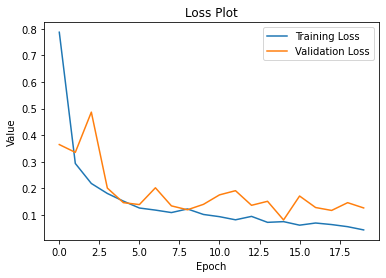

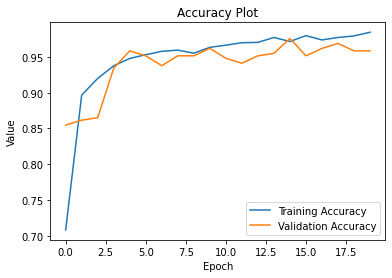

In [19]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

/content/COVID-19 Radiography Database/split/test/NORMAL/NORMAL (1106).png
[[0. 1. 0.]]
NORMAL


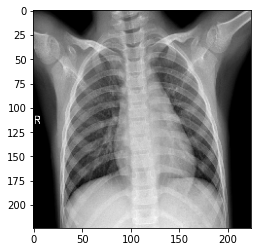

In [23]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
# upload = files.upload()
 
# for fn in upload.keys():

fn = [
      [
       "/content/COVID-19 Radiography Database/split/test/NORMAL/NORMAL (1106).png"
      ], [
       "/content/COVID-19 Radiography Database/split/test/COVID-19/COVID-19(182).png"
      ], [
          "/content/COVID-19 Radiography Database/split/test/Viral Pneumonia/Viral Pneumonia (1303).png"
      ]
]
 
path = fn[0][0]
img = image.load_img(path, target_size=(224,224))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=BATH_SIZE)

print(path)
print(classes)

if classes[0,0]!=0:
  print('COVID-19')
elif classes[0,1]!=0:
  print('NORMAL')
else:
  print("PNEUMONIA")